In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [27]:
# データの確認
print(f'データ数：{len(train)}')
print(train.head())
print('データ型:')
print(train.dtypes)
print('===========================================================')
print(f'データ数：{len(test)}')
print(test.head())

データ数：2101
    datetime   y
0 2010-07-01  17
1 2010-07-02  18
2 2010-07-03  20
3 2010-07-04  20
4 2010-07-05  14
データ型:
datetime    datetime64[ns]
y                    int64
dtype: object
データ数：365
    datetime  client  close  price_am  price_pm
0 2016-04-01       1      0         3         2
1 2016-04-02       0      0         5         5
2 2016-04-03       1      0         2         2
3 2016-04-04       1      0         1         1
4 2016-04-05       0      0         1         1


In [6]:
### 前処理 ###
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

In [7]:
# 今回は'datetime'と'y'のみを使用して分析
train = train[['datetime', 'y']]
train.head()

,datetime,y
0,2010-07-01,17
1,2010-07-02,18
2,2010-07-03,20
3,2010-07-04,20
4,2010-07-05,14


In [8]:
from statsmodels.tsa.stattools import adfuller

# ADF検定
ADF_result = adfuller(train['y'])

print(f'ADF statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF statistic: -1.4156382004506156
p-value: 0.574756432591291


In [9]:
# １次差分
y_diff1 = np.diff(train['y'], n=1)

ADF_diff1_result = adfuller(y_diff1)

print(f'ADF statistic: {ADF_diff1_result[0]}')
print(f'p-value: {ADF_diff1_result[1]}')

ADF statistic: -15.911584423633695
p-value: 8.112058795132015e-29


In [10]:
# 2次差分
y_diff2 = np.diff(y_diff1, n=1)

ADF_diff2_result = adfuller(y_diff2)

print(f'ADF statistic: {ADF_diff2_result[0]}')
print(f'p-value: {ADF_diff2_result[1]}')

ADF statistic: -17.628640445558585
p-value: 3.8078689917641585e-30


In [11]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [12]:
from tqdm.notebook import tqdm

In [13]:
### ARIMA(p,d,q)-model

def opt_ARIMA(endog: Union[pd.Series, list], order_list: list,
              d: int) -> pd.DataFrame:

              results = []

              for order in tqdm(order_list):
                try:
                  model = SARIMAX(endog, order=(order[0], d, order[1]),
                                  simple_differencing=False).fit(disp=False)
                except:
                  continue

                AIC = model.aic
                results.append([order, AIC])

              result_df = pd.DataFrame(results)
              result_df.columns = ['(p,q)', 'AIC']

              result_df = result_df.sort_values(by='AIC', 
                                                ascending=True).reset_index(drop=True)

              return result_df

In [14]:
from itertools import product

In [15]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list = list(product(ps, qs))

In [16]:
train_set = train['y'][:-10]
result_df = opt_ARIMA(train_set, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

/opt/anaconda3/envs/venv1/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(2, 3)",14879.079486
1,"(1, 1)",15011.742214
2,"(1, 3)",15011.855235
3,"(2, 1)",15012.764804
4,"(1, 2)",15012.852568
5,"(3, 1)",15012.949649
6,"(2, 2)",15014.080005
7,"(3, 2)",15014.929563
8,"(3, 3)",15017.801454
9,"(0, 3)",15046.650520


In [17]:
# AICの小さいARIMA(2,1,3)モデルを訓練データに適合させる
model = SARIMAX(train_set, order=(2,1,3), simple_differencing=False)
model_fit = model.fit(disp=False)

/opt/anaconda3/envs/venv1/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


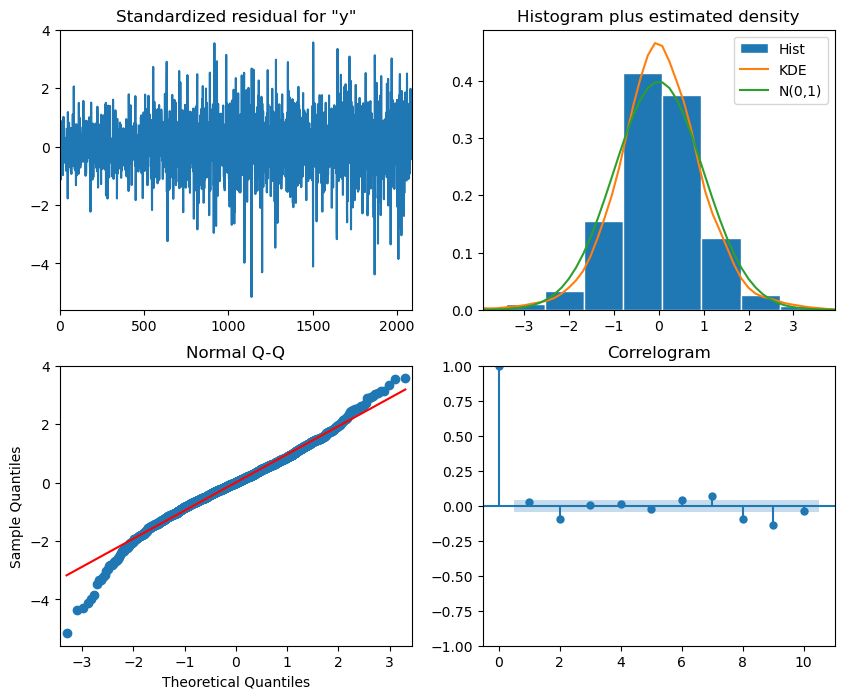

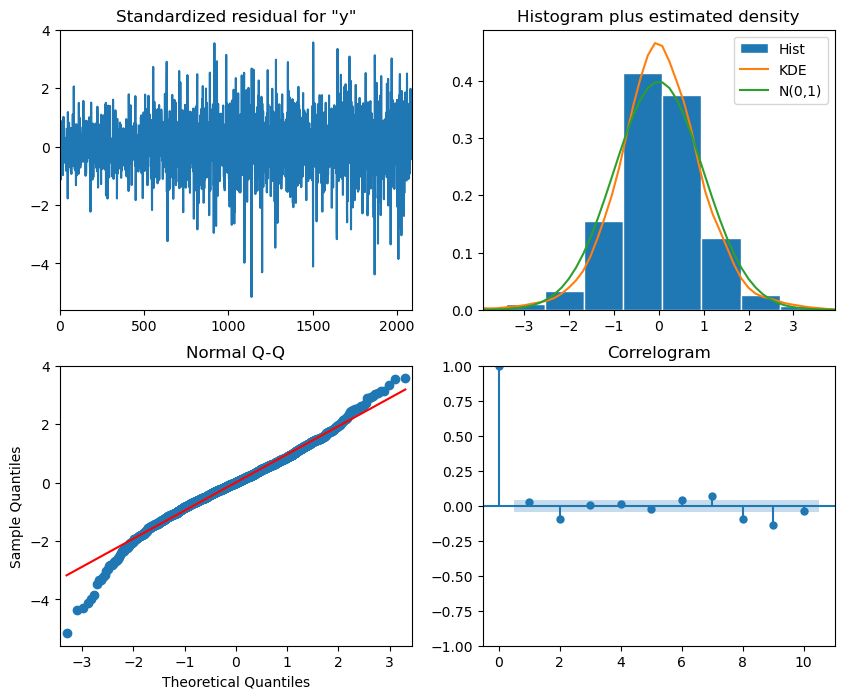

In [18]:
model_fit.plot_diagnostics(figsize=(10, 8))

In [19]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [20]:
residuals = model_fit.resid
result_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))
result_df

,lb_stat,lb_pvalue
1,1.642306,2.000094e-01
2,19.146945,6.954945e-05
3,19.165212,2.527144e-04
4,19.373143,6.637641e-04
5,20.363825,1.067717e-03
6,23.829508,5.613404e-04
7,33.255094,2.373079e-05
8,51.414243,2.183420e-08
9,91.943659,6.627564e-16
10,95.191329,4.974820e-16


In [23]:
### Prophetを使った時系列予測 ###
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


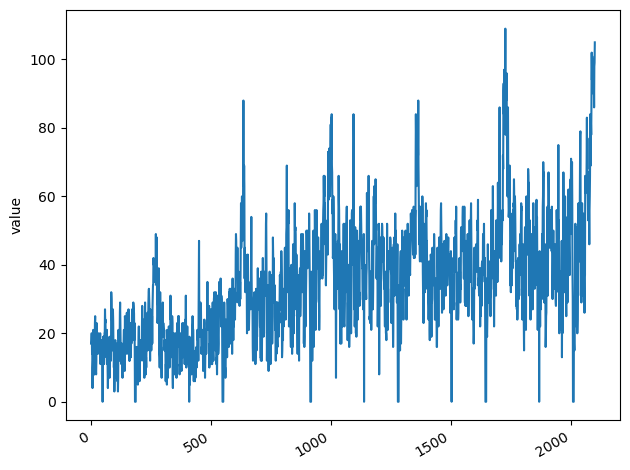

In [28]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.set_label('date')
ax.set_ylabel('value')

fig.autofmt_xdate()
plt.tight_layout()

In [31]:
train_2 = train.copy()
train_2.columns = ['ds', 'y']

train_set_2 = train_2[:-365]
test_set_2 = train_2[-365:]

In [32]:
m = Prophet()
m.fit(train_set_2)

09:50:10 - cmdstanpy - INFO - Chain [1] start processing
09:50:11 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)